In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

# Dataset for regression with observation noise
class DensityRegressionDataset(Dataset):
    def __init__(self, X, betahat, sebetahat):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.betahat = torch.tensor(betahat, dtype=torch.float32)
        self.sebetahat = torch.tensor(sebetahat, dtype=torch.float32)  # Noise level for each observation

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.betahat[idx], self.sebetahat[idx]  # Return noise_std as well


# Two-Component Mixture Density Network
class CovariateMDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers=4):
        super(CovariateMDN, self).__init__()
        # Input layer
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        # Hidden layers
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(n_layers)])
        # Output layer for pi_2
        self.pi = nn.Linear(hidden_dim, 1)  # Single output for pi_2 (pi_1 = 1 - pi_2)
        # Learnable global parameters
        self.mu_2 = nn.Parameter(torch.tensor(0.0))  # Mean of the second component
        self.log_sigma_2 = nn.Parameter(torch.tensor(0.0))  # Log of standard deviation of the second component

    def forward(self, x):
        x = torch.relu(self.fc_in(x))
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        pi_2 = torch.sigmoid(self.pi(x)).squeeze()  # Ensure pi_2 is between 0 and 1
        return pi_2, self.mu_2, self.log_sigma_2


# Loss function for two-component MDN
def two_component_mdn_loss(pi_2, mu_2, log_sigma_2, betahat, sebetahat):
    # Fixed parameters for the first component
    mu_1 = 0.0  # Mean of the point mass
    sigma_1_sq = sebetahat**2

    # Parameters for the second component
    sigma_2_sq = torch.exp(log_sigma_2)**2 + sebetahat**2

    # Gaussian PDFs
    p1 = (1 / torch.sqrt(2 * torch.pi * sigma_1_sq)) * torch.exp(-0.5 * ((betahat - mu_1) ** 2) / sigma_1_sq)
    p2 = (1 / torch.sqrt(2 * torch.pi * sigma_2_sq)) * torch.exp(-0.5 * ((betahat - mu_2) ** 2) / sigma_2_sq)

    # Mixture model likelihood
    mixture_pdf = (1 - pi_2) * p1 + pi_2 * p2

    # Negative log-likelihood
    nll = -torch.mean(torch.log(mixture_pdf + 1e-8))  # Add epsilon for numerical stability
    return nll


# Class to store the results
class CgbPosteriorMeans:
    def __init__(self, post_mean, post_mean2, post_sd, pi, loss, model_param, mu_2, sigma_2):
        self.post_mean = post_mean
        self.post_mean2 = post_mean2
        self.post_sd = post_sd
        self.loss = loss
        self.pi = pi
        self.mu_2 = mu_2
        self.sigma_2 = sigma_2
        self.model_param = model_param


# Empirical Bayes Function
def cgb_posterior_means(X, betahat, sebetahat, n_epochs=20, n_layers=4, hidden_dim=64, batch_size=128, lr=0.001, model_param=None):
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    # Standardize input features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create dataset and dataloader
    dataset = DensityRegressionDataset(X_scaled, betahat, sebetahat)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model and optimizer
    input_dim = X_scaled.shape[1]
    model = CovariateMDN(input_dim=input_dim, hidden_dim=hidden_dim, n_layers=n_layers)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    if model_param is not None:
        model.load_state_dict(model_param)

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets, noise_std in dataloader:
            optimizer.zero_grad()
            pi_2, mu_2, log_sigma_2 = model(inputs)
            loss = two_component_mdn_loss(pi_2, mu_2, log_sigma_2, targets, noise_std)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(dataloader):.4f}")

    # Extract learned parameters
    model.eval()
    with torch.no_grad():
        pi_2, mu_2, log_sigma_2 = model(torch.tensor(X_scaled, dtype=torch.float32))

    pi_np =1- pi_2.detach().numpy()
    mu_2 = mu_2.item()
    sigma_2 = np.exp(log_sigma_2.item())

    # Posterior computation
    post_mean = np.zeros_like(betahat)
    post_var = np.zeros_like(betahat)

    for i in range(len(betahat)):
        marginal_likelihood = norm.pdf(betahat[i], loc=mu_2, scale=np.sqrt(sigma_2**2 + sebetahat[i]**2))
        likelihood_point_mass = norm.pdf(betahat[i], loc=0, scale=sebetahat[i])

        w0 = pi_np[i] * likelihood_point_mass / (pi_np[i] * likelihood_point_mass + (1 - pi_np[i]) * marginal_likelihood)
        w1 = 1 - w0

        sigma_post2 = 1 / (1 / sigma_2**2 + 1 / sebetahat[i]**2)
        mu_post = sigma_post2 * (betahat[i] / sebetahat[i]**2 + mu_2 / sigma_2**2)

        post_mean[i] = w0 * 0 + w1 * mu_post
        post_var[i] = w0 * (0 - post_mean[i])**2 + w1 * (sigma_post2 + (mu_post - post_mean[i])**2)

    post_mean2 = post_var + post_mean**2

    return CgbPosteriorMeans(
        post_mean=post_mean,
        post_mean2=post_mean2,
        post_sd=np.sqrt(post_var),
        pi=pi_np,
        loss=running_loss,
        model_param=model.state_dict(),
        mu_2=mu_2,
        sigma_2=sigma_2,
    )


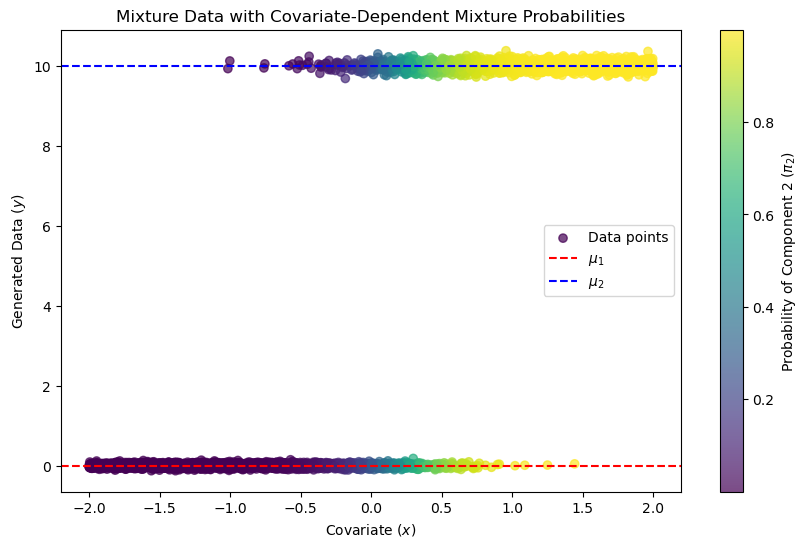

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed( 12)
n_samples = 5000
a, b = 5.0, -1.0  # Coefficients for logistic regression to control mixture probabilities
mu_1, sigma_1_sq = 0.0, 0.2
mu_2, sigma_2_sq = 10.0,  0.3


sd_noise= 1
# Covariates
x = np.random.uniform(-2, 2, n_samples)

# Mixture probabilities
pi_2 = 1 / (1 + np.exp(-(a * x + b)))  # Sigmoid function for covariate-dependent pi_2
pi_1 = 1 - pi_2  # Ensure pi_1 + pi_2 = 1

# Generate data
y = np.zeros(n_samples)
betahat = np.zeros(n_samples)
c = np.zeros(n_samples, dtype=int)  # Ensure c is an integer array
for i in range(n_samples):
    # Use .item() to extract the scalar from np.random.choice
    c[i] = np.random.choice([0, 1], p=[pi_1[i], pi_2[i]])
    if c[i] == 0:
        y[i] = np.random.normal(mu_1,  sigma_1_sq **2)
        betahat[i]= y[i]+ np.random.normal(0,  sd_noise**2)
    else:
        y[i] = np.random.normal(mu_2,  sigma_2_sq   **2 )
        betahat[i]= y[i]+ np.random.normal(0,  sd_noise**2)

 
# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=pi_2, cmap='viridis', label='Data points', alpha=0.7)
plt.colorbar(label='Probability of Component 2 ($\pi_2$)')
plt.axhline(mu_1, color='red', linestyle='--', label='$\mu_1$')
plt.axhline(mu_2, color='blue', linestyle='--', label='$\mu_2$')
plt.xlabel('Covariate ($x$)')
plt.ylabel('Generated Data ($y$)')
plt.title('Mixture Data with Covariate-Dependent Mixture Probabilities')
plt.legend()
plt.show()


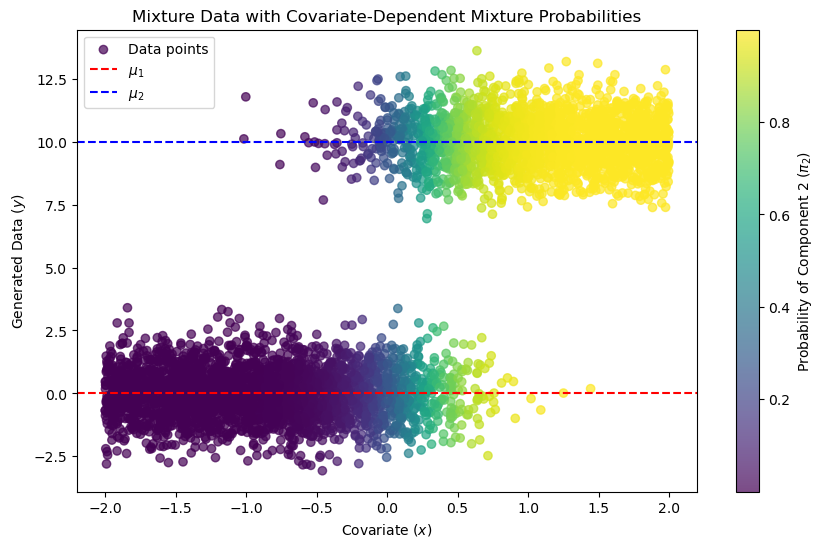

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(x, betahat, c=pi_2, cmap='viridis', label='Data points', alpha=0.7)
plt.colorbar(label='Probability of Component 2 ($\pi_2$)')
plt.axhline(mu_1, color='red', linestyle='--', label='$\mu_1$')
plt.axhline(mu_2, color='blue', linestyle='--', label='$\mu_2$')
plt.xlabel('Covariate ($x$)')
plt.ylabel('Generated Data ($y$)')
plt.title('Mixture Data with Covariate-Dependent Mixture Probabilities')
plt.legend()
plt.show()


In [24]:
sebetahat = y*0+sd_noise

In [25]:

res = cgb_posterior_means(X=x, betahat=betahat, sebetahat=sebetahat, n_epochs=100, n_layers=2)

# Display results
print("Posterior Mean (first 5):", res.post_mean[:5])
print("Posterior SD (first 5):", res.post_sd[:5])



Epoch 10/100, Loss: 6.2398
Epoch 20/100, Loss: 3.9349
Epoch 30/100, Loss: 3.1762
Epoch 40/100, Loss: 2.8484
Epoch 50/100, Loss: 2.6634
Epoch 60/100, Loss: 2.5559
Epoch 70/100, Loss: 2.5134
Epoch 80/100, Loss: 2.4901
Epoch 90/100, Loss: 2.4619
Epoch 100/100, Loss: 2.4373
Posterior Mean (first 5): [ 3.57332821e-06  1.00530227e+01  1.05379936e-02 -2.27088407e-02
  2.01422518e-09]
Posterior SD (first 5): [3.85955563e-03 9.89824993e-01 1.57646260e-01 3.69069306e-01
 1.54350862e-04]


In [26]:
print(res.sigma_2)

print(res.mu_2)

6.95638507134385
2.3266518115997314


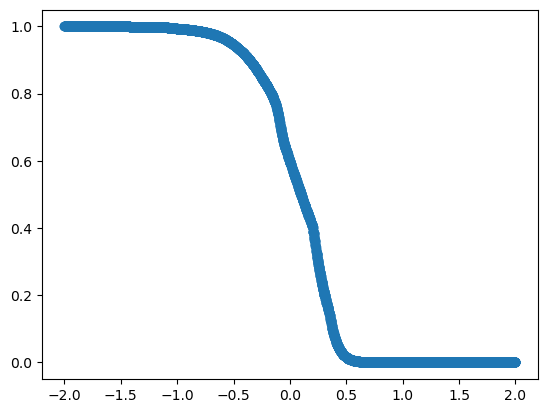

In [27]:
plt.scatter(x, res.pi)
 

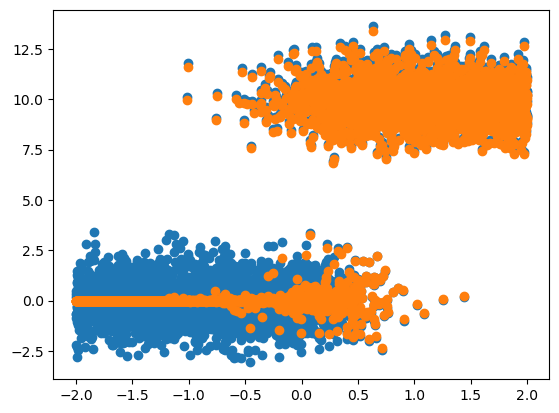

In [28]:
plt.scatter(x, betahat)
plt.scatter(x, res.post_mean)

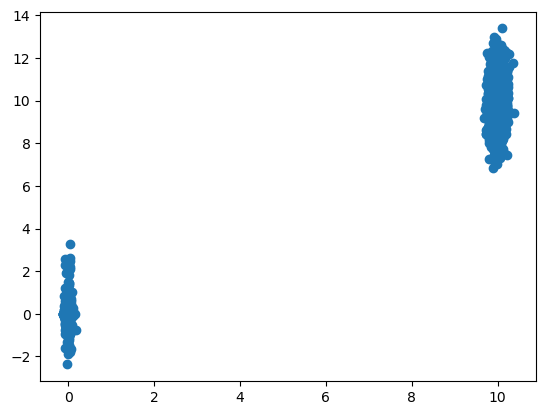

In [29]:
plt.scatter(y, res.post_mean)